In [1]:
import xarray as xr
import pandas as pd

%matplotlib inline
import fiona
import rasterio
import rasterio.mask


import datetime as dt

import numpy as np




In [7]:
AWAP_RAIN = xr.open_dataset('/g/data/oe9/project/team-drip/AWAP/AWAP_month_rain.nc')
AWAP_RAIN

<xarray.Dataset>
Dimensions:     (latitude: 270, longitude: 280, nv: 2, time: 696)
Coordinates:
  * latitude    (latitude) float64 -24.55 -24.6 -24.65 -24.7 -24.75 -24.8 ...
  * longitude   (longitude) float64 138.5 138.6 138.6 138.7 138.7 138.8 ...
  * time        (time) datetime64[ns] 1960-01-01 1960-02-01 1960-03-01 ...
Dimensions without coordinates: nv
Data variables:
    crs         (time) int32 ...
    lat_bounds  (time, latitude, nv) float64 ...
    lon_bounds  (time, longitude, nv) float64 ...
    rain_month  (time, latitude, longitude) float64 ...

### Masking shapefile

In [3]:
import fiona
import rasterio
import rasterio.mask

# create geometry coordinates of shapefile boundary 
# open the MDB shapefile 
with fiona.open("/home/563/sl1412/rainfall/mdb_boundary/mdb_boundary.shp", "r") as shapefile:
    geoms = [feature["geometry"] for feature in shapefile]
geoms

[{'coordinates': [[(146.88943187737294, -24.64027848277317),
    (146.88846192353657, -24.64262843314964),
    (146.88813201182728, -24.6451084706635),
    (146.89063199827063, -24.64569855664763),
    (146.89448180640278, -24.64440858174771),
    (146.89623178014932, -24.646038526640723),
    (146.89783188546704, -24.648238440950195),
    (146.90021184305687, -24.649868721119333),
    (146.90191169302244, -24.650628624461945),
    (146.90429165061227, -24.651228601091816),
    (146.9067316226289, -24.652168715352843),
    (146.90829166244936, -24.65333866139912),
    (146.90946160849575, -24.65547872891989),
    (146.91051169332655, -24.657618628802595),
    (146.91282174584381, -24.65924874133367),
    (146.91451170516365, -24.660008644676225),
    (146.91677146626188, -24.660318607455963),
    (146.91872143221843, -24.660508709020178),
    (146.92097147030887, -24.662538638333046),
    (146.9220614529989, -24.665318747980905),
    (146.92318144290215, -24.66693863459011),
    (146.9

In [4]:
# mask the SPI raster based on geoms 
with rasterio.open("/g/data/oe9/project/team-drip/Rainfall/rain_month_Layer1.tif") as src:
    out_image, out_transform = rasterio.mask.mask(src, geoms,
                                                        crop=True)
    out_meta = src.meta.copy()

In [5]:
out_meta

{'count': 1,
 'crs': CRS({'init': 'epsg:4326'}),
 'driver': 'GTiff',
 'dtype': 'float64',
 'height': 270,
 'nodata': -999.0,
 'transform': Affine(0.05000000000000071, 0.0, 138.475,
       0.0, -0.05000000000000068, -24.524999999999807),
 'width': 280}

In [6]:
out_transform # Affine transform variable used for rasterise the geoms 

Affine(0.05000000000000071, 0.0, 138.52500000000001,
       0.0, -0.05000000000000068, -24.574999999999807)

In [8]:
shape_data = AWAP_RAIN.rain_month.isel(time=0).shape
shape_data # shape of the raster (no. of col and no. of rows)

(270, 280)

In [10]:
# create masking array 
import rasterio
from rasterio import features
mask = xr.DataArray(
    features.rasterize(geoms, out_shape=shape_data, transform=out_transform, all_touched= False),
    coords=AWAP_RAIN.rain_month.isel(time=0).coords,
)
mask

<xarray.DataArray (latitude: 270, longitude: 280)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
Coordinates:
  * latitude   (latitude) float64 -24.55 -24.6 -24.65 -24.7 -24.75 -24.8 ...
  * longitude  (longitude) float64 138.5 138.6 138.6 138.7 138.7 138.8 138.8 ...
    time       datetime64[ns] 1960-01-01

/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/xarray/plot/utils.py:51: FutureWarning: 'pandas.tseries.converter.register' has been moved and renamed to 'pandas.plotting.register_matplotlib_converters'. 
  converter.register()


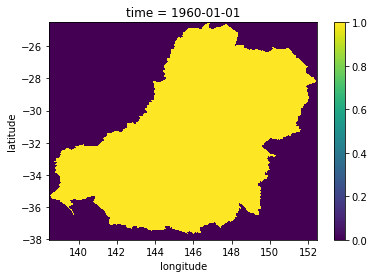

In [11]:
mask.plot.imshow()

In [14]:
subset_RAIN = AWAP_RAIN.where(mask, drop=True)
subset_RAIN

<xarray.Dataset>
Dimensions:     (latitude: 261, longitude: 278, nv: 2, time: 696)
Coordinates:
  * latitude    (latitude) float64 -24.6 -24.65 -24.7 -24.75 -24.8 -24.85 ...
  * longitude   (longitude) float64 138.6 138.6 138.7 138.7 138.8 138.8 ...
  * time        (time) datetime64[ns] 1960-01-01 1960-02-01 1960-03-01 ...
Dimensions without coordinates: nv
Data variables:
    crs         (time, latitude, longitude) float64 nan nan nan nan nan nan ...
    lat_bounds  (time, latitude, nv, longitude) float64 nan nan nan nan nan ...
    lon_bounds  (time, longitude, nv, latitude) float64 nan nan nan nan nan ...
    rain_month  (time, latitude, longitude) float64 nan nan nan nan nan nan ...

In [16]:
path = '/g/data/oe9/project/team-drip/AWAP/AWAP_month_rain_masked.nc'
subset_RAIN.to_netcdf(path, mode = 'w')

In [15]:
# save the mask array into a nc file 
path = '/g/data/oe9/project/team-drip/MDB_MASK/MASK_ARRAY_AWAP.nc'
mask.to_netcdf(path, mode = 'w')

In [45]:
mask

<xarray.DataArray (y: 3147, x: 3346)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
Coordinates:
    band     int64 2
  * y        (y) float64 -24.59 -24.59 -24.6 -24.6 -24.6 -24.61 -24.61 ...
  * x        (x) float64 138.6 138.6 138.6 138.6 138.6 138.6 138.6 138.6 ...
    time     datetime64[ns] 2000-02-18